# Определение перспективного тарифа для телеком компании

**Цели и задачи:** Провести анализ тарифов на выборке клиентов оператора сотовой связи. Определить профиль пользователей: необходимые услуги сотового оператора (звонки, сообщения, интернет трафик), используемый тариф. Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**План выполнения работы:**

- 1. Изучение общей информации о данных
- 1. Подготовка данных
     - 2.1 Преобразование данных в таблицах
     - 2.2 Расчёт дополнительных данных для пользователей
     - 2.3 Устранение выбросов в данных
- 1. Анализ Данных
     - 3.1 Анализ минут разговора
     - 3.2 Анализ количества сообщений
     - 3.3 Анализ интернет трафика
     - 3.4 Анализ выручки по тарифам
- 1. Проверка гипотез
     - 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт»
     - 4.2 Средняя выручка пользователей из Москвы и других регионов
     - 4.3 Альтернативные методы проверки гипотез
- 1. Общий вывод

**Описание данных:**
Оператор сотовой связи предлагает клиентам два тарифа. Необходимо выяснить наиболее выгодный вариант для разных клиентов.

- **Таблица `users`** (информация о пользователях):
  `user_id` — уникальный идентификатор пользователя
  `first_name` — имя пользователя
  `last_name` — фамилия пользователя
  `age` — возраст пользователя (годы)
  `reg_date` — дата подключения тарифа (день, месяц, год)
  `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
  `city` — город проживания пользователя
  `tariff` — название тарифного плана
- **Таблица `calls`** (информация о звонках):
  `id` — уникальный номер звонка
  `call_date` — дата звонка
  `duration` — длительность звонка в минутах
  `user_id` — идентификатор пользователя, сделавшего звонок
- **Таблица `messages`** (информация о сообщениях):
  `id` — уникальный номер сообщения
  `message_date` — дата сообщения
  `user_id` — идентификатор пользователя, отправившего сообщение
- **Таблица `internet`** (информация об интернет-сессиях):
  `id` — уникальный номер сессии
  `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
  `session_date` — дата интернет-сессии
  `user_id` — идентификатор пользователя
- **Таблица `tariffs`** (информация о тарифах):
  `tariff_name` — название тарифа
  `rub_monthly_fee` — ежемесячная абонентская плата в рублях
  `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
  `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
  `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
  `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
  `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
  `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

<b>Просмотр информации о звонках</b>

In [3]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


<b>Просмотр информации об интернет-сессиях</b>

In [5]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


<b>Просмотр информации о сообщениях</b>

In [7]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


<b>Просмотр информации о тарифах</b>

In [9]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


<b>Просмотр информации о пользователях</b>

In [11]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

Предоставлено пять файлов с данными:
- В файле с информацией о звонках (calls.csv) 4 столбца, 2 из которых имеют строковый тип, 1 - вещественный и 1 - целочисленный. В файле 202607 строк, пропущенных значений нет. Объем данных порядка 6,2 МБ.
- В файле с информацией об интернет-сессиях (internet.csv) 5 столбцов, 2 из которых имеют строковый тип, 1 - вещественный и 2 - целочисленный. В файле 149396 строк, пропущенных значений нет. Объем данных порядка 5,7 МБ.
- В файле с информацией о сообщениях (messages.csv) 3 столбца, 2 из которых имеют строковый тип и 1 - целочисленный. В файле 123036 строк, пропущенных значений нет. Объем данных порядка 2,8 МБ.
- В файле с информацией о тарифах (tariffs.csv) 8 столбцов, 1 из которых имеет строковый тип, остальные - целочисленный. В файле 2 строки, пропущенных значений нет. Объем данных порядка 256 байт.
- В файле с информацией о пользователях (users.csv) 8 столбцов, 6 из которых имеют строковый тип и 2 - целочисленный. В файле 500 строк, есть пропущенные значения в столбце churn_date. Объем данных порядка 31,4 КБ.

## Подготовка данных

### Приведение данных к нужным типам

<b>Приведение данных, содержащих дату, время, к формату datetime</b>

In [13]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

<b>Округление продолжительности звонков в большую сторону</b>

In [14]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

### Вывод

Данные, имеющие формат даты, приведены к типу datetime для удобства дальнейшей работы с ними. <br>
Так как по условиям использования тарифов компания "Мегалайн" округляет неполную минуту разговора в большую сторону, значения столбца 'duration' (продолжительность звонка) округлены в большую сторону.

### Работа с ошибками в данных

<b>Поиск дубликатов</b>

In [15]:
for data in [df_calls, df_internet, df_messages, df_tariffs, df_users]:
    print('Количество дубликатов: ', data.duplicated().sum())

Количество дубликатов:  0
Количество дубликатов:  0
Количество дубликатов:  0
Количество дубликатов:  0
Количество дубликатов:  0


<b>Получение развернутых характеристик</b>

In [16]:
df_calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,7.158198,5.959173,0.0,2.0,6.0,11.0,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [17]:
df_internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [18]:
df_messages.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


In [19]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


<b>Работа с пропусками</b>

In [20]:
df_users['churn_date'] = df_users['churn_date'].fillna(0)

<b>Выяснение количества звонков продолжительностью 0 минут</b>

In [21]:
print('Количество звонков продолжительностью 0 минут:', df_calls.loc[df_calls['duration'] == 0, 'duration'].count())

Количество звонков продолжительностью 0 минут: 39613


In [22]:
print('Объем звонков продолжительностью 0 минут: {:.2%}'.format(len(df_calls.query('duration == 0')) / len(df_calls)))

Объем звонков продолжительностью 0 минут: 19.55%


### Вывод

Дубликаты в данных не обнаружены. <br>
При просмотре развернутых числовых характеристик аномальных значений не обнаружено. <br>
Пропущенные значения в столбце 'churn_date' (дата прекращения договора) таблицы с информацией о пользователях (df_users) заменены на 0 для удобства дальнейшей работы с ними. Причина появления большого количества пропущенных значений в данном столбце - факт того, что на момент формирования выборки клиенты не прекращали пользоваться услугами компании "Мегалайн". <br>
Анализ данных показал налчие в выборке большого количества звонков, продолжительностью 0 минут (порядка 20%). Вероятнее всего, это связано с тем, что пользователи не смогли дозвониться (не было связа у абонента, линия была занята и т.п.). Принято решение оставить эти данные, так как они влиияют на показатель количества сделанных звонков.

### Анализ использования тарифа и определение дохода от каждого пользователя по месяцам

<b>Подсчет для каждого пользователя количества сделанных звонков и израсходованных минут разговора по месяцам</b>

In [23]:
df_calls['month'] = df_calls['call_date'].dt.month
calls_count = df_calls.pivot_table(values=['id', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'id': 'count', 'duration': 'sum'})
calls_count.columns = ['duration', 'calls']

<b>Подсчет для каждого пользователя количества отправленных сообщений по месяцам</b>

In [24]:
df_messages['month'] = df_messages['message_date'].dt.month
messages_count = df_messages.pivot_table(values='id', 
                       index=['user_id', 'month'], 
                       aggfunc='count')
messages_count.columns = ['messages']

<b>Подсчет для каждого пользователя объема израсходованного интернет-трафика по месяцам</b>

In [25]:
df_internet['month'] = df_internet['session_date'].dt.month
internet_count = df_internet.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc='sum')

<b>Вычисление помесячной выручки с каждого пользователя</b>

In [26]:
df_pivot_tables = [calls_count, messages_count, internet_count]
df_grouped = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), df_pivot_tables)

for user in df_grouped.index:
    df_grouped.loc[user, 'tariff'] = df_users.loc[user[0]-1000, 'tariff']
    
df_grouped = df_grouped.fillna(0)
    
df_grouped.loc[df_grouped['tariff'] == 'smart', 'profit_for_minutes'] = (df_grouped['duration'] - 500)*3
df_grouped.loc[df_grouped['tariff'] == 'ultra', 'profit_for_minutes'] = df_grouped['duration'] - 3000

df_grouped.loc[df_grouped['tariff'] == 'smart', 'profit_for_messages'] = (df_grouped['messages'] - 50)*3
df_grouped.loc[df_grouped['tariff'] == 'ultra', 'profit_for_messages'] = df_grouped['messages'] - 1000

df_grouped.loc[df_grouped['tariff'] == 'smart', 'profit_for_internet'] = ((df_grouped['mb_used']/1000 - 15)*200).round(1)
df_grouped.loc[df_grouped['tariff'] == 'ultra', 'profit_for_internet'] = ((df_grouped['mb_used']/1000 - 30)*150).round(1)

df_grouped.loc[df_grouped['profit_for_minutes'] < 0, 'profit_for_minutes'] = 0
df_grouped.loc[df_grouped['profit_for_messages'] < 0, 'profit_for_messages'] = 0
df_grouped.loc[df_grouped['profit_for_internet'] < 0, 'profit_for_internet'] = 0

df_grouped.loc[df_grouped['tariff'] == 'smart', 'total_profit'] = 550+df_grouped['profit_for_minutes']+df_grouped['profit_for_messages']+df_grouped['profit_for_internet']
df_grouped.loc[df_grouped['tariff'] == 'ultra', 'total_profit'] = 1950+df_grouped['profit_for_minutes']+df_grouped['profit_for_messages']+df_grouped['profit_for_internet']

df_grouped.head(20)

duration  calls  messages   mb_used tariff  profit_for_minutes  \
user_id month                                                                   
1000    5         159.0   22.0      22.0   2253.49  ultra                 0.0   
        6         172.0   43.0      60.0  23233.77  ultra                 0.0   
        7         340.0   47.0      75.0  14003.64  ultra                 0.0   
        8         408.0   52.0      81.0  14055.93  ultra                 0.0   
        9         466.0   58.0      57.0  14568.91  ultra                 0.0   
        10        350.0   57.0      73.0  14702.49  ultra                 0.0   
        11        338.0   43.0      58.0  14756.47  ultra                 0.0   
        12        333.0   46.0      70.0   9817.61  ultra                 0.0   
1001    11        430.0   59.0       0.0  18429.34  smart                 0.0   
        12        414.0   63.0       0.0  14036.66  smart                 0.0   
1002    6         117.0   15.0       4.0  10856.82  smart                 0.0   
        7         214.0   26.0      11.0  17580.10  smart                 0.0   
        8         289.0   42.0      13.0  20319.26  smart                 0.0   
        9         206.0   36.0       4.0  16691.08  smart                 0.0   
        10        212.0   33.0      10.0  13888.25  smart                 0.0   
        11        243.0   32.0      16.0  18587.28  smart                 0.0   
        12        236.0   33.0      12.0  18113.73  smart                 0.0   
1003    8         380.0   55.0      37.0   8565.21  ultra                 0.0   
        9         961.0  134.0      91.0  12468.87  ultra                 0.0   
        10        855.0  108.0      83.0  14768.14  ultra                 0.0   

               profit_for_messages  profit_for_internet  total_profit  
user_id month                                                          
1000    5                      0.0                  0.0        1950.0  
        6                      0.0                  0.0        1950.0  
        7                      0.0                  0.0        1950.0  
        8                      0.0                  0.0        1950.0  
        9                      0.0                  0.0        1950.0  
        10                     0.0                  0.0        1950.0  
        11                     0.0                  0.0        1950.0  
        12                     0.0                  0.0        1950.0  
1001    11                     0.0                685.9        1235.9  
        12                     0.0                  0.0         550.0  
1002    6                      0.0                  0.0         550.0  
        7                      0.0                516.0        1066.0  
        8                      0.0               1063.9        1613.9  
        9                      0.0                338.2         888.2  
        10                     0.0                  0.0         550.0  
        11                     0.0                717.5        1267.5  
        12                     0.0                622.7        1172.7  
1003    8                      0.0                  0.0        1950.0  
        9                      0.0                  0.0        1950.0  
        10                     0.0                  0.0        1950.0

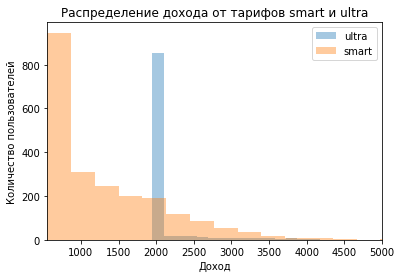

In [27]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df_grouped.query('tariff == @tariff')['total_profit'], kde=False, label=tariff, bins=20)
_ = plt.legend(['ultra', 'smart'])
plt.xlim(550, 5000)
plt.title('Распределение дохода от тарифов smart и ultra')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.show()

In [28]:
print('Медианные показатели ежемесячных трат на услуги связи пользователей тарифов Smart и Ultra: ')
df_grouped.pivot_table(index='tariff', values='total_profit', aggfunc='median')

Медианные показатели ежемесячных трат на услуги связи пользователей тарифов Smart и Ultra: 


,total_profit
tariff,
smart,1023.6
ultra,1950.0


### Вывод

Клиентам, использующим тариф ultra, преимущественно, хватает объема услуг, которые предоставляет тариф, доход с одного клиента при этом, практически равен стоимости тарифа в месяц (1950 руб.). <br>
Клиентам, использующим тариф smart, далеко не всегда хватает объема услуг, предоставляемого тарифным планом, им довольно часто приходится покупать дополнительный объем услуг, в результате чего доход от тарифа smart несколько выше чем от тарифа ultra.

## Анализ данных

<b>Числовые характеристики данных</b>

In [29]:
df_grouped[['duration', 'calls', 'messages', 'mb_used', 'tariff', 'total_profit']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,3214.0,451.244866,241.909978,0.0,282.00,443.000,589.000,1673.00
calls,3214.0,63.038892,33.236368,0.0,40.00,62.000,82.000,244.00
messages,3214.0,38.281269,36.148326,0.0,9.00,30.000,57.000,224.00
mb_used,3214.0,17207.612859,7570.958771,0.0,12491.89,16943.175,21424.625,49745.69
total_profit,3214.0,1529.001867,806.734073,550.0,727.00,1643.700,1950.000,6880.50


<b>Нахождение медианы, дисперсии, стандартного отклонения</b>

In [30]:
print('Медианное значение продолжительности звонков, мин.: ', df_grouped['duration'].median())
print('Медианное значение количества вызовов: ', df_grouped['calls'].median())
print('Медианное значение количества сообщений: ', df_grouped['messages'].median())
print('Медианное значение потраченного интернет-траффика, МБ: ', df_grouped['mb_used'].median().round(1))

Медианное значение продолжительности звонков, мин.:  443.0
Медианное значение количества вызовов:  62.0
Медианное значение количества сообщений:  30.0
Медианное значение потраченного интернет-траффика, МБ:  16943.2


In [31]:
duration_variance = np.var(df_grouped['duration'])
print('Дисперсия продолжительности звонков: ', duration_variance.round(1))
calls_variance = np.var(df_grouped['calls'])
print('Дисперсия количества звонков: ', calls_variance.round(1)) 
messages_variance = np.var(df_grouped['messages'])
print('Дисперсия количества сообщений: ', messages_variance.round(1))
internet_variance = np.var(df_grouped['mb_used'])
print('Дисперсия использовния интернет-траффика: ', (internet_variance/1000).round(1))

Дисперсия продолжительности звонков:  58502.2
Дисперсия количества звонков:  1104.3
Дисперсия количества сообщений:  1306.3
Дисперсия использовния интернет-траффика:  57301.6


In [32]:
duration_standart = np.sqrt(duration_variance)
print('Стандартное отклонение продолжительности звонков: ', duration_standart.round(1)) 
calls_standart = np.sqrt(calls_variance)
print('Стандартное отклонение количества звонков: ', calls_standart.round(1)) 
messages_standart = np.sqrt(messages_variance)
print('Стандартное отклонение количества сообщений: ', messages_standart.round(1)) 
internet_standart = np.sqrt(internet_variance)
print('Стандартное отклонение использования интернет-траффика: ', internet_standart.round(1)) 

Стандартное отклонение продолжительности звонков:  241.9
Стандартное отклонение количества звонков:  33.2
Стандартное отклонение количества сообщений:  36.1
Стандартное отклонение использования интернет-траффика:  7569.8


In [33]:
df_stat = df_grouped.pivot_table(index=['tariff'], values=['duration', 'calls', 'messages', 'mb_used'], 
                    aggfunc={'duration': [np.median, np.var, np.std],
                             'calls': [np.median, np.var, np.std],
                             'messages': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std]})
df_stat

calls                         duration                             \
       median        std          var   median         std            var   
tariff                                                                      
smart    60.0  25.939858   672.876243    422.0  190.313730   36219.315784   
ultra    74.0  43.916853  1928.689990    518.0  317.606098  100873.633397   

         mb_used                             messages                          
          median           std           var   median        std          var  
tariff                                                                         
smart   16506.84   5870.476681  3.446250e+07     28.0  28.227876   796.812958  
ultra   19308.01  10087.170752  1.017510e+08     38.0  47.804457  2285.266143

<b>Построение графиков</b>

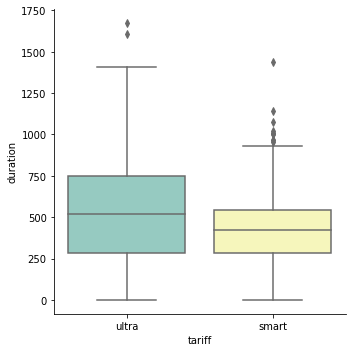

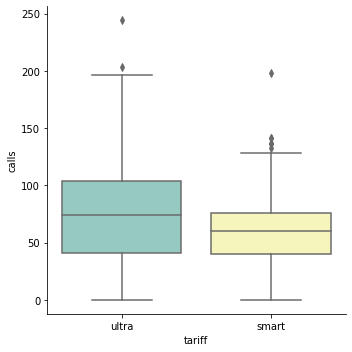

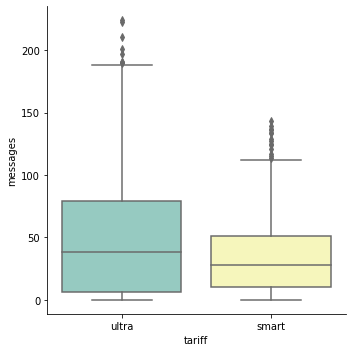

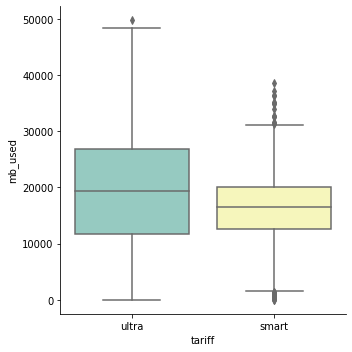

In [34]:
for column in ['duration', 'calls', 'messages', 'mb_used']:    
    sns.catplot(x='tariff', y=column, kind='box', data=df_grouped, palette='Set3')

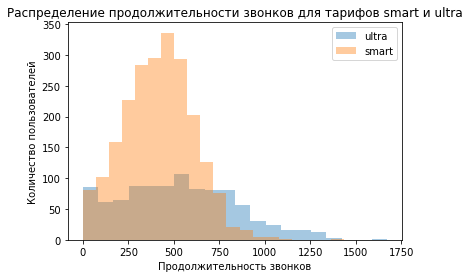

In [35]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df_grouped.query('tariff == @tariff')['duration'], kde=False, label=tariff, bins=20)
_ = plt.legend(['ultra', 'smart'])
plt.title('Распределение продолжительности звонков для тарифов smart и ultra')
plt.xlabel('Продолжительность звонков')
plt.ylabel('Количество пользователей')
plt.show()

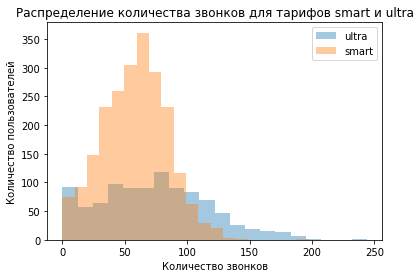

In [36]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df_grouped.query('tariff == @tariff')['calls'], kde=False, label=tariff, bins=20)
_ = plt.legend(['ultra', 'smart'])
plt.title('Распределение количества звонков для тарифов smart и ultra')
plt.xlabel('Количество звонков')
plt.ylabel('Количество пользователей')
plt.show()

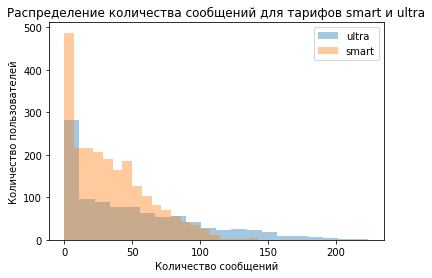

In [37]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df_grouped.query('tariff == @tariff')['messages'], kde=False, label=tariff, bins=20)
_ = plt.legend(['ultra', 'smart'])
plt.title('Распределение количества сообщений для тарифов smart и ultra')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

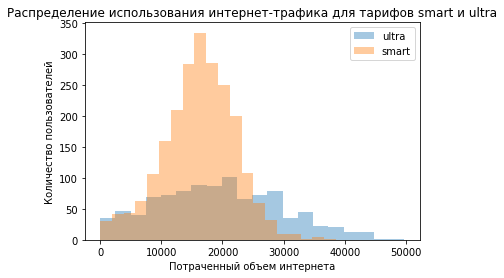

In [38]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df_grouped.query('tariff == @tariff')['mb_used'], kde=False, label=tariff, bins=20)
_ = plt.legend(['ultra', 'smart'])
plt.title('Распределение использования интернет-трафика для тарифов smart и ultra')
plt.xlabel('Потраченный объем интернета')
plt.ylabel('Количество пользователей')
plt.show()

<b>Использование тарифов по месяцам</b>

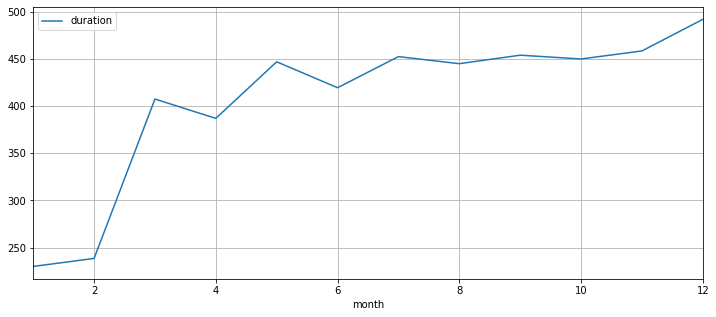

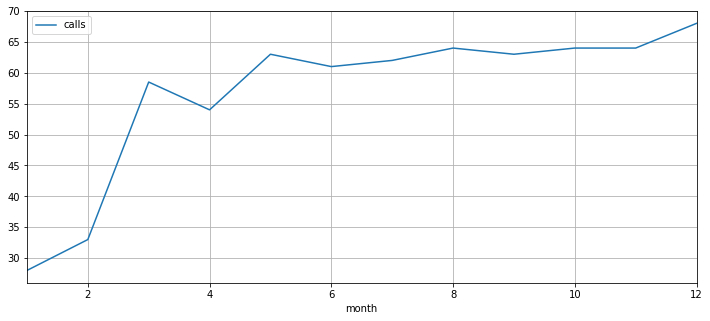

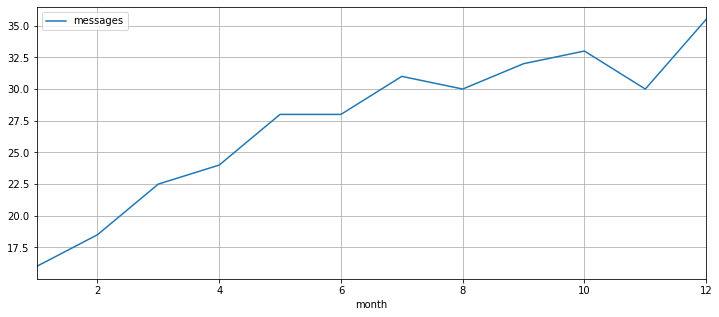

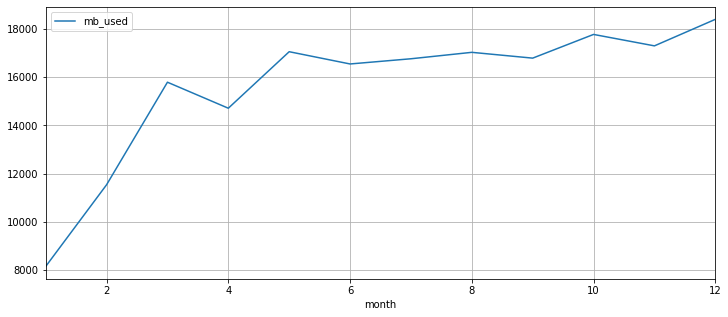

In [39]:
for column in ['duration', 'calls', 'messages', 'mb_used']:
    df_grouped.pivot_table(index='month', values=column, aggfunc='median').plot(grid=True, figsize=(12, 5))

### Вывод

На диаграммах размаха, построенных для характеристик продолжительности звонков, колчесвта звонков, количества сообщений и использования интернет-трафика видно, что для тарифа Ultra дисперсия больше, нежели для тарифа Smart. В то же время у тарифа Smart больше выбросов, чем у тарифа Ultra. <br>
На гистограммах сравнения объемов использования услуг тарифов пользователями прослеживается закономерность того, что диапазон тарифа Smart уже, чем диапазон тарифа  Ultra. Возможно, это связано с тем, что у тарифа Smart меньше изначальный объем предоставляемых услуг, пользователи более аккуратно его расходуют. Но в то же время тарифом Smart пользовалось больше клиентов компании, чем тарифом Ultra, что связано с более низкой ценой тарифа Smart. <br>
На графиках, отображающих использование услуг тарифных планов по месяцам, прослеживается тенденция к увеличению расходования пользователями услуг. Особенно резкий рост прослеживается после февраля.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

<b>Н0</b> (нулевая гипотеза): предположим, что средняя выручка пользователей тарифов "Ультра" и "Смрат" одинакова, тогда альтернативная гипотеза <b>Н1</b>: средняя выручка пользователей тарифов "Ультра" больше, нежели средняя выручка пользователей тарифа "Смрат". <br> Если нулевая гипотеза верна, то будем считать, что пользователи тарифов "Смарт" и "Ультра" тратят одинаковые суммы на услуги связи.

In [40]:
ultra = df_grouped.query('tariff == "ultra"')['total_profit']
smart = df_grouped.query('tariff == "smart"')['total_profit']

alpha = .05

results = st.ttest_ind(ultra, smart, equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.9824062544717144e-248
Отвергаем нулевую гипотезу


### Вывод

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

<b>H0</b>: предположим, что средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов. <br>
<b>H1</b>: предположим, что средняя выручка пользователей из Москвы не равна средней выручки пользователей из других регионов. <br>
Если нулевая гипотеза верна, то будем считать, что пользователи из Москвы и из других регионов тратят одинаковые суммы на услуги связи.

In [41]:
df_merge_users = df_grouped.merge(df_users, on='user_id')

In [42]:
moscow_users = df_merge_users.query('city == "Москва"')['total_profit']
other_users = df_merge_users.query('city != "Москва"')['total_profit']

alpha = .05

results = st.ttest_ind(moscow_users, other_users, equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5116672562917901
Не получилось отвергнуть нулевую гипотезу


### Вывод

Средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов.

## Вывод

Произведен анализ тарифов компании "Мегалайн" на основании данных использвоания тарифов "Смарт" и "Ультра" 500 пользователями за 2018 год.<br>
Произведена подготовка данных к анализу, в результате которой данные, содержащие информацию о дате, приведены к соответствующему типу, а продолжительность разговора в минутах округлена в большую сторону в соответствии с условиями использования тарифов компанией. Также обработаны прпущенные значения в данных, содержащих дату прекращения договора о пользовании услугами связи. <br>
Анализ данных показал, что пользователи тарифа "Смарт" стремятся "уложиться" в отведенные тарифом лимиты, но достаточно часто, им не хватает предоставляемых услуг, из-за чего приходится оплачивать дополнительный объем услуг приблизительно на 400-500 рублей в месяц. Пользователям тарифа "Ультра", как правило, хватает предоставляемого объема услуг. Но в то же время из-за дороговизны тарифа "Ультра" большая часть клиентов компании отдают предпочтение более доступному по цене тарифу "Смарт", что, как выяснилось в ходе дальнейшего анализа, связано с тем, что доход пользователей тарифа "Смарт" отличается от дохода пользователей тарифа "Ультра".  <br>
Что касается дифференцияции доходов пользователей в зависимости от региона проживания, то в ходе проведения анализа предоставленной выборки была опровергнута гипотеза о неравенстве доходов пользователей из Москвы и других регионов. <br>
В общем, можно сделать вывод, что компании "Мегалайн" стоит пересмотреть тарифные планы, так как на текущий момент трудно выделить оптимальный для большинства пользователей тариф. В качестве рекомендации, возможно пересмотреть тариф "Смарт" в сторону увеличения предоставляемого объема услуг с соответствующим увеличением стоимости. В то же время для тарифа "Ультра" следовало бы несколько уменьшить объем предоставляемых услуг с соответствующим уменьшением стоимости. Также как вариант возможна разработка третьего тарифа, являющегося промежуточным между тарифами "Смарт" и "Ультра".